In [1]:
import os
import sys
import timeit
import numpy as np
import theano
import theano.tensor as T
import lasagne
from theano.tensor.signal import pool
from theano.tensor.nnet import conv2d
from logistic_sgd import load_data
from lasagne.layers import get_output, InputLayer, DenseLayer, Upscale2DLayer, ReshapeLayer
import gzip
import pickle

Using gpu device 0: TITAN X (Pascal) (CNMeM is disabled, cuDNN 5105)


In [2]:
batch_size = 1000
f = gzip.open('/home/rui/Downloads/mnist.pkl.gz', 'rb')
try:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
except:
    train_set, valid_set, test_set = pickle.load(f)
f.close()
X_train, y_train = train_set
y_train = np.asarray(y_train, dtype = np.int32)
X_test, y_test = test_set
y_test = np.asarray(y_test, dtype = np.int32)

In [3]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]



In [4]:
class LogisticRegression(object):
    def __init__(self, X, y, num_units=10):
        self.X = X
        self.y = y
        self.input_var = T.matrix('inputs')
        self.target_var = T.ivector('targets')
        self.l_in = InputLayer(shape=(None, X.shape[1]), input_var=self.input_var)
        self.l_out = DenseLayer(self.l_in, num_units=num_units, nonlinearity=lasagne.nonlinearities.softmax)
        self.prediction = lasagne.layers.get_output(self.l_out)
        self.loss = lasagne.objectives.categorical_crossentropy(self.prediction, self.target_var)
        self.loss = self.loss.mean()
        self.params = lasagne.layers.get_all_params(self.l_out, trainable=True)
        self.updates = lasagne.updates.adadelta(self.loss, self.params, learning_rate=1)
        
        self.test_prediction = lasagne.layers.get_output(self.l_out, deterministic=True)
        self.test_loss = lasagne.objectives.categorical_crossentropy(self.test_prediction,
                                                            self.target_var)
        self.test_loss = self.test_loss.mean()
        self.test_acc = T.mean(T.eq(T.argmax(self.test_prediction, axis=1), self.target_var),
                      dtype=theano.config.floatX)
        self.train_fn = theano.function([self.input_var, self.target_var],
                                        self.loss, updates=self.updates)
        self.acc_fn = theano.function([self.input_var, self.target_var], 
                                      self.test_acc)
        self.train()
        
    def train(self, num_epochs=50, batch_size=1000):
        for epoch in range(num_epochs):
            train_err = 0
            train_batches = 0
            for batch in iterate_minibatches(self.X, self.y, batch_size, shuffle=False):
                inputs, targets = batch
                train_err += self.train_fn(inputs, targets)
                train_batches += 1

    def eval_acc(self, X_test, y_test):
        test_acc = 0
        test_batches = 0
        for batch in iterate_minibatches(X_test, y_test, 1000, shuffle=False):
            inputs, targets = batch
            test_acc += self.acc_fn(inputs, targets)
            test_batches += 1
        self.test_acc = test_acc/test_batches
        print('overall acc is: {}'.format(self.test_acc))

In [5]:
lr = LogisticRegression(X_train, y_train)

# Logistic regression on original data

In [6]:
lr.eval_acc(X_test, y_test)

overall acc is: 0.9245000064373017


In [7]:
acc_list = []
benchmark_acc = lr.test_acc
acc_list.append(lr.test_acc)

In [8]:
hidden_neurons = 512

input_var = T.matrix('inputs')
target_var = T.ivector('target')
l_in = InputLayer(shape=(None, 784), input_var=input_var)
pre_layer = l_in
hidden_layer_list = []
for i in range(20):
    h_layer = DenseLayer(pre_layer, num_units=hidden_neurons)
    hidden_layer_list.append(h_layer)
    pre_layer = h_layer
output_list = lasagne.layers.get_output(hidden_layer_list)
output_fn = theano.function([input_var], output_list)

In [9]:
feature_list = output_fn(X_train)

In [10]:
test_feature_list = output_fn(X_test)

In [11]:
for i in range(20):
    X = feature_list[i]
    lr = LogisticRegression(X, y_train)
    print('hidden layer {}:'.format(i+1))
    lr.eval_acc(test_feature_list[i], y_test)
    acc_list.append(lr.test_acc)

hidden layer 1:
overall acc is: 0.9353999972343445
hidden layer 2:
overall acc is: 0.9217000007629395
hidden layer 3:
overall acc is: 0.8981999933719635
hidden layer 4:
overall acc is: 0.8653999984264373
hidden layer 5:
overall acc is: 0.8254999995231629
hidden layer 6:
overall acc is: 0.7629000067710876
hidden layer 7:
overall acc is: 0.6960999965667725
hidden layer 8:
overall acc is: 0.5989999949932099
hidden layer 9:
overall acc is: 0.4825999945402145
hidden layer 10:
overall acc is: 0.3836999982595444
hidden layer 11:
overall acc is: 0.2966999977827072
hidden layer 12:
overall acc is: 0.23200000077486038
hidden layer 13:
overall acc is: 0.19659999907016754
hidden layer 14:
overall acc is: 0.1588000014424324
hidden layer 15:
overall acc is: 0.12190000116825103
hidden layer 16:
overall acc is: 0.1135000005364418
hidden layer 17:
overall acc is: 0.1135000005364418
hidden layer 18:
overall acc is: 0.1135000005364418
hidden layer 19:
overall acc is: 0.1135000005364418
hidden layer 20:
o

In [12]:
acc_list = np.asarray(acc_list)
err = 1-acc_list

# Notice that inserting a hidden layer(even the weights are random) helps to train a better classifier

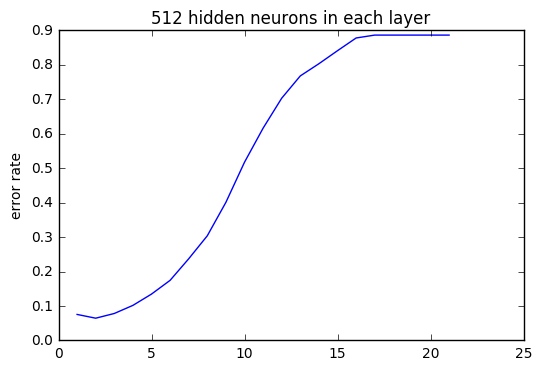

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(1,len(err)+1),err)
plt.title('512 hidden neurons in each layer')
plt.ylabel('error rate')
plt.savefig('512_err.png')

hidden layer 1:
overall acc is: 0.9482000052928925
hidden layer 2:
overall acc is: 0.9409999966621398
hidden layer 3:
overall acc is: 0.9241000056266785
hidden layer 4:
overall acc is: 0.8979999959468842
hidden layer 5:
overall acc is: 0.8684000134468078
hidden layer 6:
overall acc is: 0.8269000113010406
hidden layer 7:
overall acc is: 0.7857000052928924
hidden layer 8:
overall acc is: 0.7194000005722045
hidden layer 9:
overall acc is: 0.6337000072002411
hidden layer 10:
overall acc is: 0.5254999905824661
hidden layer 11:
overall acc is: 0.40840000212192534
hidden layer 12:
overall acc is: 0.2996000021696091
hidden layer 13:
overall acc is: 0.2201999992132187
hidden layer 14:
overall acc is: 0.17559999972581863
hidden layer 15:
overall acc is: 0.13269999995827675
hidden layer 16:
overall acc is: 0.1135000005364418
hidden layer 17:
overall acc is: 0.1135000005364418
hidden layer 18:
overall acc is: 0.1135000005364418
hidden layer 19:
overall acc is: 0.1135000005364418
hidden layer 20:
o

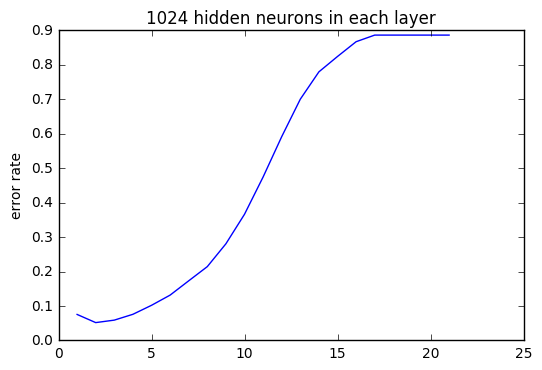

In [17]:
hidden_neurons = 1024

acc_list = []
acc_list.append(benchmark_acc)
input_var = T.matrix('inputs')
target_var = T.ivector('target')
l_in = InputLayer(shape=(None, 784), input_var=input_var)
pre_layer = l_in
hidden_layer_list = []
for i in range(20):
    h_layer = DenseLayer(pre_layer, num_units=hidden_neurons)
    hidden_layer_list.append(h_layer)
    pre_layer = h_layer
output_list = lasagne.layers.get_output(hidden_layer_list)
output_fn = theano.function([input_var], output_list)
feature_list = output_fn(X_train)
test_feature_list = output_fn(X_test)
for i in range(20):
    X = feature_list[i]
    lr = LogisticRegression(X, y_train)
    print('hidden layer {}:'.format(i+1))
    lr.eval_acc(test_feature_list[i], y_test)
    acc_list.append(lr.test_acc)
acc_list = np.asarray(acc_list)
err = 1-acc_list
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(1,len(err)+1),err)
plt.title('{} hidden neurons in each layer'.format(hidden_neurons))
plt.ylabel('error rate')
plt.savefig('{}_err.png'.format(hidden_neurons))